Here are DUNE FD values:

FD1 (NE): 1417.62 m, 3986.75 mwe; 103.7546341 W, 44.3459914 N

FD2 (SE): 1392.17 m, 3866.89 mwe; 103.7548042 W, 44.3450261 N

FD3 (NW): 1405.13 m, 3942.87 mwe; 103.7556732 W, 44.3460857 N

FD4 (SW): 1404.21 m, 3885.87 mwe; 103.7558433 W, 44.3451204 N

The highest point of the detector caverns is 126.62 m (415.42 ft) above sea level.

## Let's generate an indepedent Sun angular distribution for 10 years at DUNE's location.

In [19]:
# Create a Pandas DatetimeIndex range every 20 days 1hour and 10 minutes, in my timezone:

import matplotlib.pyplot as plt
from matplotlib import colors 
import numpy as np

import pandas as pd
import dunestyle.matplotlib as dunestyle
import math as m

# Define the start and end dates for a 10-year range
start_date = '2030-01-01'
end_date = '2040-01-01'

# Create a date range with 100,000 points over the 10 years
dti = pd.date_range(start=start_date, end=end_date, periods=100000)

# Set the geographic location to Arnhem, the Netherlands (we'll use degrees in SolTrack):
geo_lon =  -103.75 # Positive -> east of Greenwich (degrees)
geo_lat = 44.34 # Positive -> northern hemisphere (degrees)

# Create a SolTrack instance and specify preferences:
from soltrack import SolTrack
st = SolTrack(geo_lon, geo_lat, use_degrees=True)  # Use default values for all but use_degrees
#st.altitude = alt
st.set_date_time(dti)  # Pass my dates and times to SolTrack
st.compute_position()  # Compute the Sun's position
st.compute_rise_set()  # Compute the rise and set times of the Sun


# Print some selected results as arrays and create chaos:
#if st.lt is not None:  # If local time was used
 #   print('Local time:     ', *st.lt)  # Asterisk (*) unpacks the DTI
    
#print('UTC:            ', *st.utc)
#print('azimuth:        ', *st.azimuth)
#print('altitude:       ', *st.altitude)
#print('distance:       ', *st.distance)
#print('riseTime:       ', *st.rise_time)
#print('transTime:      ', *st.transit_time)
#print('setTime:        ', *st.set_time)


# Store selected results in a Pandas DataFrame and print that in a more orderly fashion:
st.create_df(utc=True, jd=True, ecl=True, rts_pos=True)
#with pd.option_context('display.max_columns',None, 'display.width',None):  # Want all columns
 #   print(st.df)

## Convert to Honda coordinates

In [20]:

# Function for converting to Honda flux coordinates
def convert_to_honda_flux_coordinates(row):
    altitude = row['altitude']
    azimuth = row['azimuth']
    
    # Calculate the zenith angle and Honda azimuth
    zenith_angle = 90 - altitude
    honda_azimuth = azimuth 
    
    return pd.Series([zenith_angle, honda_azimuth])

# Apply the function and add the results as new columns in the DataFrame
st.df[['zenith_angle', 'honda_azimuth']] = st.df.apply(convert_to_honda_flux_coordinates, axis=1)


### Plot angular distribution in zenith and azimuth

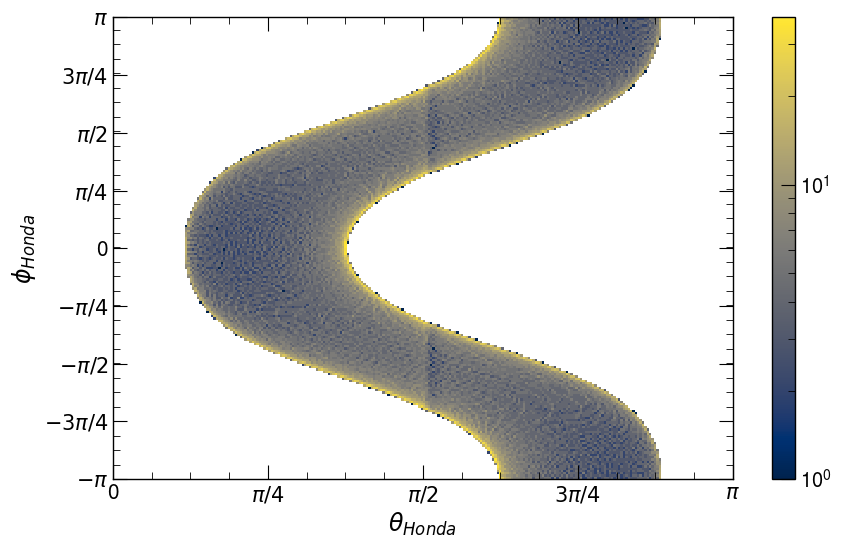

In [21]:

fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

theta_honda = np.array(st.df['zenith_angle'])*(np.pi/180) 
phi_honda = np.array(st.df['honda_azimuth'])*(np.pi/180) 


h = ax.hist2d(theta_honda,phi_honda, bins=(200,200), norm = colors.LogNorm())
ax.set_xlabel(r'$\theta_{Honda}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
plt.show()

## Use the rotation matrix to get the coordinates in Detector coordinates system

In [22]:
import numpy as np
FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL

Inverse_FluxRotValues = np.linalg.inv(FluxRotValues)




In [23]:
x = np.cos(phi_honda)*np.sin(theta_honda)
y = np.sin(phi_honda)*np.sin(theta_honda)
z = np.cos(theta_honda)

In [24]:
coordinates = np.vstack((x, y, z))
coordinates_transposed = np.column_stack((x, y, z))

In [25]:
coords_sun_det = [FluxRotValues.dot(coord) for coord in coordinates_transposed]
coords_sun_det = np.array(coords_sun_det)
coords_sun_det

array([[ 0.2968015 , -0.10852848, -0.94875842],
       [ 0.14815309, -0.25766363, -0.95481493],
       [ 0.00624809, -0.40729166, -0.91328237],
       ...,
       [ 0.58269118,  0.15812656, -0.79716932],
       [ 0.44401936,  0.03705503, -0.89525749],
       [ 0.29652771, -0.10963372, -0.94871696]])

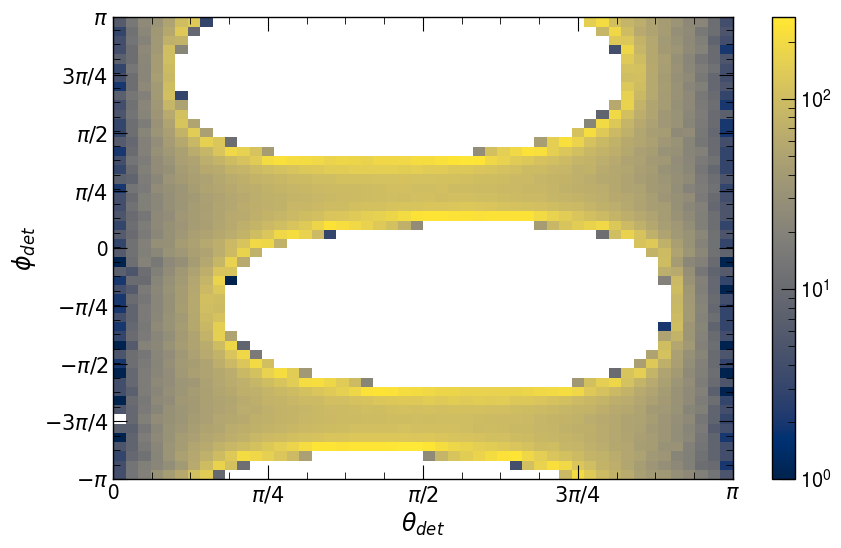

In [26]:
import math
fig, ax = plt.subplots(figsize=(10, 6))

h = plt.hist2d(np.arccos(coords_sun_det[:,2]),np.arctan2(coords_sun_det[:,1], coords_sun_det[:,0]), bins = (50,50),  norm = colors.LogNorm())
ax.set_xlabel(r'$\theta_{det}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{det}$', fontsize = 17)
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
plt.show()

### Let's try to see if this is slight allignement w.r.t Sun is due to the horizon

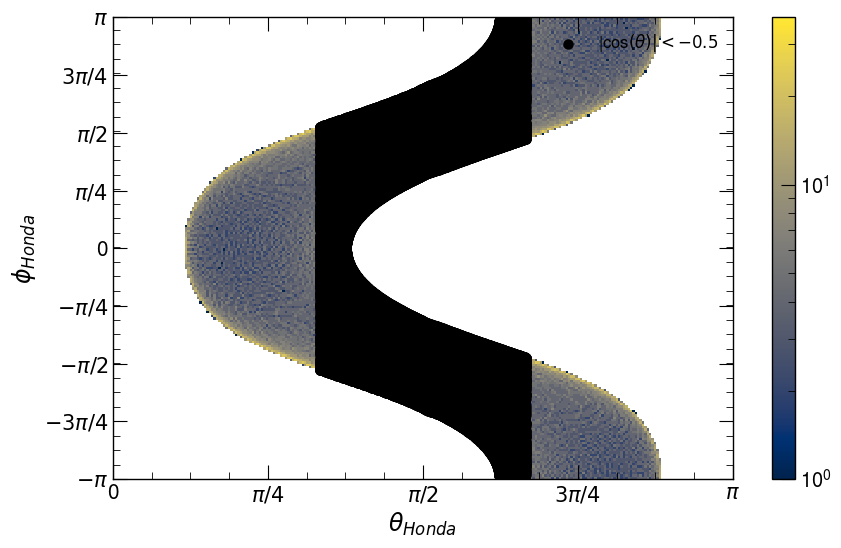

In [43]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

theta_honda = np.array(st.df['zenith_angle'])*(np.pi/180) 
phi_honda = np.array(st.df['honda_azimuth'])*(np.pi/180) 

cos_theta_honda = np.cos(theta_honda)
h = ax.hist2d(theta_honda,phi_honda, bins=(200,200), norm = colors.LogNorm())
ax.scatter(theta_honda[np.abs(cos_theta_honda) < 0.5], phi_honda[np.abs(cos_theta_honda) < 0.5],label = r'|cos$(\theta)| <-0.5 $')
ax.set_xlabel(r'$\theta_{Honda}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.legend()
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
plt.show()

/tmp/ipykernel_9381/1931273172.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


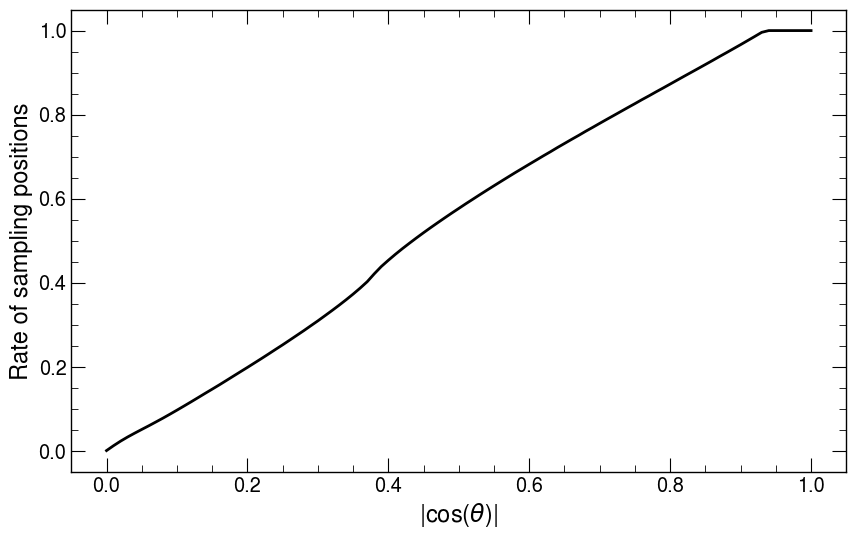

In [54]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

cos_theta_honda = np.cos(theta_honda)
cos = np.linspace(0,1,101)
rate_sun = [cos_theta_honda[np.abs(cos_theta_honda) < i].size/cos_theta_honda.size for i in cos]
#h = ax.hist2d(theta_honda,phi_honda, bins=(200,200), norm = colors.LogNorm())
ax.plot(cos, rate_sun)
ax.set_xlabel(r'|cos($\theta$)|', fontsize = 17)
ax.set_ylabel(r'Rate of sampling positions', fontsize = 17)

ax.legend()

#fig.colorbar(h[3], ax=ax)
plt.show()

In [55]:
def resultsTOtxt(arr,  filename):
#arr is the concatenated and transposed array of all the arrays wished to be written
#arrDescription a string describing and is each collumn of the file
#writes out each array concatenated in arr as an collumn in the file
    file = open(filename, 'w')
    np.savetxt(filename, arr, delimiter=' ')
    file.close()
    
def GetNpArraysFromTrees(tree, branch_name):
    estimate = 3e6 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), dtype=np.float64, count=result_hist))
    result = result.copy()
    return result

def GetNpArraysFromTrees2(tree, branch_name):
    estimate = 3e8 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), count=result_hist))
    result = result.copy()
    return result

In [56]:
import ROOT
def ReadNuclearModelSamples(IsBDM, massANDboost=None):
    if IsBDM:
        fBDM_00a = ROOT.TFile.Open("/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_"+massANDboost+"_00a.root")
        if massANDboost != 'm20_b10':
            fBDM_01a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01a_newVertex/bdm_'+massANDboost+'_01a.root')
        fBDM_02a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02a_newVertex/bdm_'+massANDboost+'_02a.root')
        fBDM_00b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00b_newVertex/bdm_'+massANDboost+'_00b.root')
        fBDM_01b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01b_newVertex/bdm_'+massANDboost+'_01b.root')
        fBDM_02b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02b_newVertex/bdm_'+massANDboost+'_02b.root')
        if massANDboost != 'm20_b10':
            samples = [fBDM_00a, fBDM_01a, fBDM_02a, fBDM_00b, fBDM_01b, fBDM_02b]
        else:
            samples = [fBDM_00a, fBDM_02a, fBDM_00b, fBDM_01b, fBDM_02b]
        return samples
    if not IsBDM:
        fAtm_00a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/atm_hA_BR_4ana.root')
        fAtm_01a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01a_newVertex/atm_hA_LFG.root')
        fAtm_02a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02a_newVertex/atm_hA_ESF.root')
        fAtm_00b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00b_newVertex/atm_hN_BR.root')
        fAtm_01b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01b_newVertex/atm_hN_LFG.root')
        fAtm_02b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02b_newVertex/atm_hN_ESF.root')
        samples = [fAtm_00a, fAtm_01a, fAtm_02a, fAtm_00b, fAtm_01b, fAtm_02b]
        return samples

In [57]:
def vec_mod(arr):
    return math.sqrt(arr[0]**2+arr[1]**2+arr[2]**2)

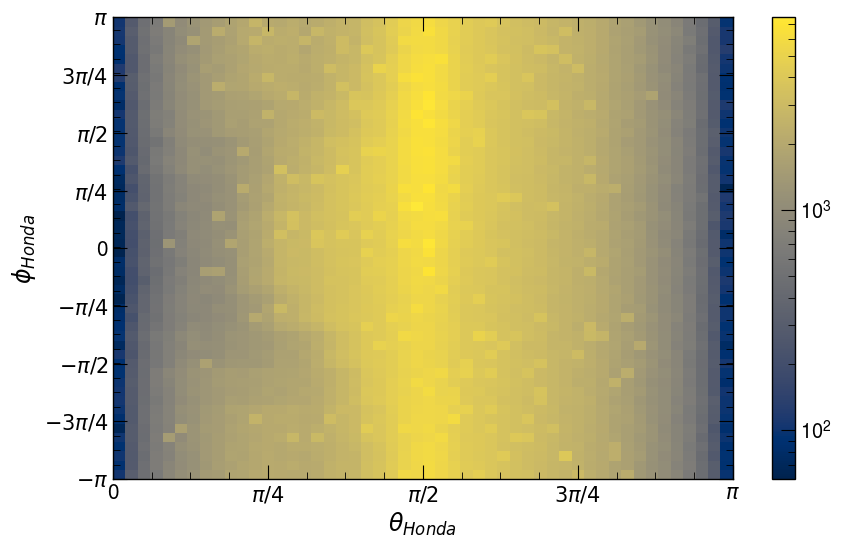

In [70]:

infiles_list = ReadNuclearModelSamples(False)
intrees_reco = [lambda arg=infile: arg.Get("ana/Atm") for infile in infiles_list]
intrees_simu = [lambda arg=infile: arg.Get("ana/AllEvents") for infile in infiles_list]
reco_entries = [intree().GetEntries() for intree in intrees_reco]
    
MCNuMomentum = [GetNpArraysFromTrees2(func(),"MCNuMomentum") for func in intrees_reco]
NuMom_True = [nuclearmodel.reshape(reco_entries[i_sample],3) for i_sample, nuclearmodel in enumerate(MCNuMomentum)]
NuMom_True_Unit = [[Inverse_FluxRotValues.dot(evt/vec_mod(evt)) for evt in nuclearmodel] for nuclearmodel in NuMom_True]
plot_dirdetc_nu = []
Phi_Theta_NuMom_Unit = [[plot_dirdetc_nu.append((math.atan2(nu[1], nu[0]), math.acos(nu[2]))) for nu in nuclearmodel] for nuclearmodel in NuMom_True_Unit]
plot_dirdetc_nu = np.array(plot_dirdetc_nu)
    
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

h = ax.hist2d(plot_dirdetc_nu[:,1],plot_dirdetc_nu[:,0], bins = (50,50),  norm = colors.LogNorm(), label = ' # Events')
ax.set_xlabel(r'$\theta_{Honda}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{Honda}$', fontsize = 17)
#plt.title('Atmospheric Neutrinos True Direction in Geographical Coordinates (Honda Flux)')
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
#plt.title('Atmospherics_'+list_nuclearmodels[SAMPLE_INDEX])
plt.show()


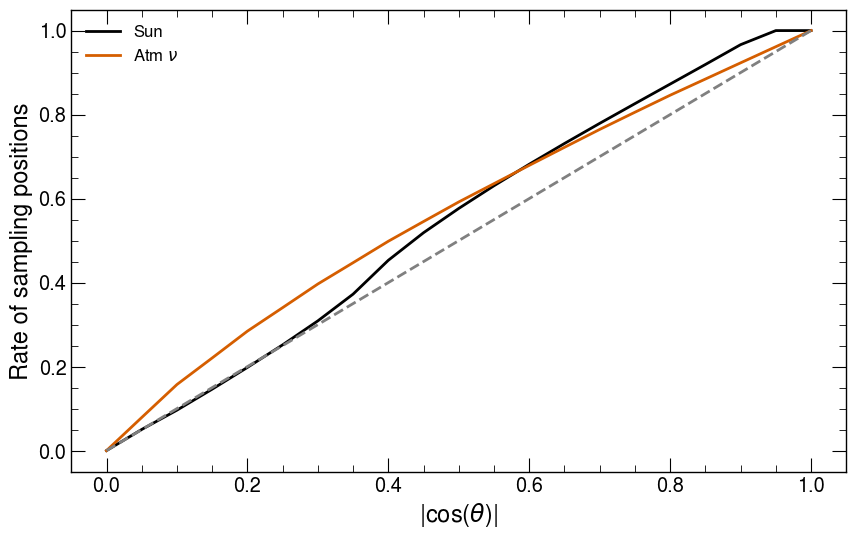

In [69]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

cos_theta_honda = np.cos(theta_honda)
cos_theta_atm = np.cos(plot_dirdetc_nu[:,1])
cos = np.linspace(0,1,21)
rate_sun = [cos_theta_honda[np.abs(cos_theta_honda) < i].size/cos_theta_honda.size for i in cos]
rate_atm = [cos_theta_atm[np.abs(cos_theta_atm) < i].size/cos_theta_atm.size for i in cos]
#h = ax.hist2d(theta_honda,phi_honda, bins=(200,200), norm = colors.LogNorm())
ax.plot(cos, rate_sun, label = 'Sun')
ax.plot(cos,rate_atm, label = r'Atm $\nu$')
ax.plot(cos,cos, ls = '--', color= 'gray')
# Compute the derivative
#dy_dx_sun = np.gradient(rate_sun, cos)  # Numerical derivative
#dy_dx_atm = np.gradient(rate_atm, cos)  # Numerical derivative

#ax.plot(cos, dy_dx_sun, linestyle="--")
#ax.plot(cos, dy_dx_atm, linestyle="--")
ax.set_xlabel(r'|cos($\theta$)|', fontsize = 17)
ax.set_ylabel(r'Rate of sampling positions', fontsize = 17)

ax.legend()

#fig.colorbar(h[3], ax=ax)
plt.show()

## Calculating 

In [73]:
print(cos_theta_honda[np.abs(cos_theta_honda) <0.5].size/cos_theta_honda.size)
print(cos_theta_atm[np.abs(cos_theta_atm) <0.5].size/cos_theta_atm.size)

0.57657
0.5920228743479934


In [74]:
print(cos_theta_honda[np.abs(cos_theta_honda) >0.5].size/cos_theta_honda.size)
print(cos_theta_atm[np.abs(cos_theta_atm) >0.5].size/cos_theta_atm.size)

0.42343
0.40797712565200656


### Use the Honda Fulx tables to get an independent angular distribution w.r.t Sun.

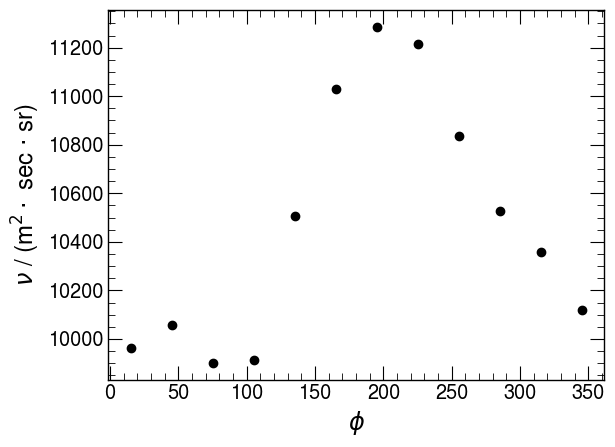

In [18]:
file = 'HondaFluxTables/hms-nu-20-12-n3650.d'

flux_mu = []
flux_mub = []
flux_e = []
flux_eb = []

for i in np.arange(0, 240, 1):                               
  var = np.loadtxt(file, unpack=True, skiprows=2+103*(i), max_rows=101)
  flux_mu.append(var[1])
  flux_mub.append(var[2])
  flux_e.append(var[3])
  flux_eb.append(var[4])
E = var[0]


# Integrate in E
flux_mu = np.array([np.trapz(flux_mu[i], E) for i in range(240)])
flux_mub = np.array([np.trapz(flux_mub[i], E) for i in range(240)])
flux_e = np.array([np.trapz(flux_e[i], E) for i in range(240)])
flux_eb = np.array([np.trapz(flux_eb[i], E) for i in range(240)])


# Average in cZ
flux_mu = np.array([sum(flux_mu[i::12])*0.1 for i in range(12)])
flux_mub = np.array([sum(flux_mub[i::12])*0.1 for i in range(12)])
flux_e = np.array([sum(flux_e[i::12])*0.1 for i in range(12)])
flux_eb = np.array([sum(flux_eb[i::12])*0.1 for i in range(12)])

#Total Flux
Flux = flux_mu+flux_mub+flux_e+flux_eb

plt.plot(np.arange(15, 375, 30), Flux, 'o')
plt.xlabel(rf'$\phi$')
plt.ylabel(r'$\nu$ / (m$^2\cdot$ sec $\cdot$ sr)')

#plt.yscale('log')
plt.show()